In [27]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from scipy.stats import ttest_1samp, ttest_rel, sem, t, zscore, chi2_contingency, fisher_exact
import pingouin as pg
sns.set_style('whitegrid')

In [28]:
df_no_latency = pd.read_pickle("preprocessed_data/preprocessed_no_latency.pkl")
df_with_latency = pd.read_pickle("preprocessed_data/preprocessed_with_latency.pkl")

### Jedem Trial ein "slow_trial" hinzufügen, welches anhand der median RT gegeben wird. (Langsamer Trial = 1; Schneller Trial = 0)

In [29]:
df_no_latency["reactiontime"] = pd.to_numeric(df_no_latency["reactiontime"])
df_no_latency["median_rt"] = df_no_latency.groupby("participant_num")["reactiontime"].transform("median")
df_no_latency["slow_trial"] = (df_no_latency["reactiontime"] > df_no_latency["median_rt"]).astype(int)

df_with_latency["reactiontime"] = pd.to_numeric(df_with_latency["reactiontime"])
df_with_latency["median_rt"] = df_with_latency.groupby("participant_num")["reactiontime"].transform("median")
df_with_latency["slow_trial"] = (df_with_latency["reactiontime"] > df_with_latency["median_rt"]).astype(int)

#### 4 Prädikatoren

direction(n) = **currentdirection** (1 = right; 0 = left) </br>
location(n) = **currentlocation** (1 = right; 0 = left) </br>
response(n - 1) = reflects previous (correct) response and hence the **previousdirection** (1 = right; 0 = left) </br>
congruency(n - 1) reflects the expected influence of the direction(n - 1)/location(n - 1), **previouscongruency** (1 = congruent, 0 = incongruent) 

In [30]:
def compute_trajectory_angles(xpos, ypos):
    if len(xpos) < 2 or len(ypos) < 2:
        return np.nan  
    
    x_array = np.array(xpos)
    y_array = np.array(ypos)

    delta_x = np.diff(x_array)  
    delta_y = np.diff(y_array)  
    
    # Compute angles relative to Y-axis
    angles_rad = np.arctan2(delta_x, delta_y)  
    
    # Normalize angles between -1 and 1
    angles_normalized = angles_rad / np.pi
    
    return angles_normalized.tolist()  

Umwandeln von 0ern der Prädikatoren in -1 Werte

In [31]:
predictor_columns = ["currentdirection", "currentlocation", "previousresponse", "previouscongruency"]

df_no_latency = df_no_latency.rename(columns={"previousdirection": "previousresponse"})
df_with_latency = df_with_latency.rename(columns={"previousdirection": "previousresponse"})


df_no_latency[predictor_columns] = df_no_latency[predictor_columns].replace(0, -1)
df_with_latency[predictor_columns] = df_with_latency[predictor_columns].replace(0, -1)

#### Berechnen der Trajectory Angles (100 Zeitschritte)

In [32]:
df_no_latency["trajectory_angle"] = df_no_latency.apply(lambda row: compute_trajectory_angles(row["xpos"], row["ypos"]), axis=1)
df_with_latency["trajectory_angle"] = df_with_latency.apply(lambda row: compute_trajectory_angles(row["xpos"], row["ypos"]), axis=1)

print(df_no_latency["trajectory_angle"].iloc[0]) 
print(df_with_latency["trajectory_angle"].iloc[0]) 

[0.0, 0.0, 0.0, -0.011958540456714366, -0.06960448727306393, -0.06298636053191246, -0.01980971959788098, -0.11454548957280279, -0.25939882537924736, 0.0, -0.2380689698427858, -0.09742520095620845, -0.1596655293982666, -0.2389834881151767, -0.20483276469913356, -0.10834693614812307, -0.18388561284073984, -0.20997787377357782, -0.21984390452160765, -0.2499999999999993, -0.2500000000000007, -0.22666798624647247, -0.231688244596965, -0.2570515025248739, -0.2788579383763045, -0.2545340221976979, -0.24999999999999778, 0.0, 0.0, 0.0, 0.23744165604921483, 0.36718542570760054, 0.3571943473983582, 0.3241555954522046, 0.3055998877857848, 0.23219881787003982, 0.24067111170153946, 0.1807680226635889, 0.009382339984868822, 0.0525684567112535, 0.007668633741357628, 0.0, -0.05885313502045133, -0.12722793095810522, -0.09277357907774236, -0.15257745622457583, -0.13858919622156252, -0.13670356894997035, -0.1496240376912004, -0.16524934053856805, -0.13652782806909744, -0.16039201831743957, -0.171453725659

#### Berechnen der Beta-Gewichte und Grand averages

In [33]:
def get_beta_weights_per_participant(df):
    x = df[predictor_columns].values
    x = sm.add_constant(x)

    participant_ids = df["participant_num"].unique()
    beta_weights_per_participant = {p_id: np.zeros((4, 100)) for p_id in participant_ids}

    for participant in participant_ids:
        participant_trials = df[df["participant_num"] == participant]
        traj_matrix = np.array(participant_trials["trajectory_angle"].tolist())

        x_participant = participant_trials[predictor_columns].values
        x_participant = sm.add_constant(x_participant)

        for t in range(99):
            y = traj_matrix[:, t]

            if y.shape[0] < 2:
                continue

            model = sm.OLS(y, x_participant).fit()
            beta_weights_per_participant[participant][:, t] = model.params[1:]

    return beta_weights_per_participant

def get_mean_times_per_participant(df):
    return df.groupby("participant_num")["reactiontime"].mean().reset_index()
    
def trajectory_angle_multiple_regression(df):
    beta_weights_per_participant = get_beta_weights_per_participant(df)
    
    beta_avg = np.mean(np.array(list(beta_weights_per_participant.values())), axis = 0)

    beta_df = pd.DataFrame(beta_avg.T, columns=predictor_columns)

    return beta_df

In [34]:
# Splitting into slow and fast bins
with_latency_fast = df_with_latency[df_with_latency["slow_trial"] == 0]
with_latency_slow = df_with_latency[df_with_latency["slow_trial"] == 1]

no_latency_fast = df_no_latency[df_no_latency["slow_trial"] == 0]
no_latency_slow = df_no_latency[df_no_latency["slow_trial"] == 1]

In [35]:
beta_weights_per_participant_with_latency_fast = get_beta_weights_per_participant(with_latency_fast)
beta_weights_per_participant_with_latency_slow = get_beta_weights_per_participant(with_latency_slow)
beta_weights_per_participant_no_latency_fast = get_beta_weights_per_participant(no_latency_fast)
beta_weights_per_participant_no_latency_slow = get_beta_weights_per_participant(no_latency_slow)

mean_reactiontimes_per_participant_with_latency_fast = get_mean_times_per_participant(with_latency_fast)
mean_reactiontimes_per_participant_with_latency_slow = get_mean_times_per_participant(with_latency_slow)
mean_reactiontimes_per_participant_no_latency_fast = get_mean_times_per_participant(no_latency_fast)
mean_reactiontimes_per_participant_no_latency_slow = get_mean_times_per_participant(no_latency_slow)

beta_weights_with_latency_fast = trajectory_angle_multiple_regression(with_latency_fast)
beta_weights_with_latency_slow = trajectory_angle_multiple_regression(with_latency_slow)
beta_weights_no_latency_fast = trajectory_angle_multiple_regression(no_latency_fast)
beta_weights_no_latency_slow = trajectory_angle_multiple_regression(no_latency_slow)

beta_weights_all = [{"weights": beta_weights_with_latency_fast, "label": "with latency (fast trials)"}, {"weights": beta_weights_with_latency_slow, "label": "with latency (slow trials)"},
{"weights": beta_weights_no_latency_fast, "label": "without latency (fast trials)"}, {"weights": beta_weights_no_latency_slow, "label": "without latency (slow trials)"}]

In [36]:
mean_reactiontimes_per_participant_no_latency_fast

,participant_num,reactiontime
0,1,338.899676
1,2,381.560403
2,3,377.879085
3,4,378.933110
4,5,372.291139
5,6,376.827362
6,7,360.959732
7,8,356.627586
8,9,332.358423
9,10,390.993590


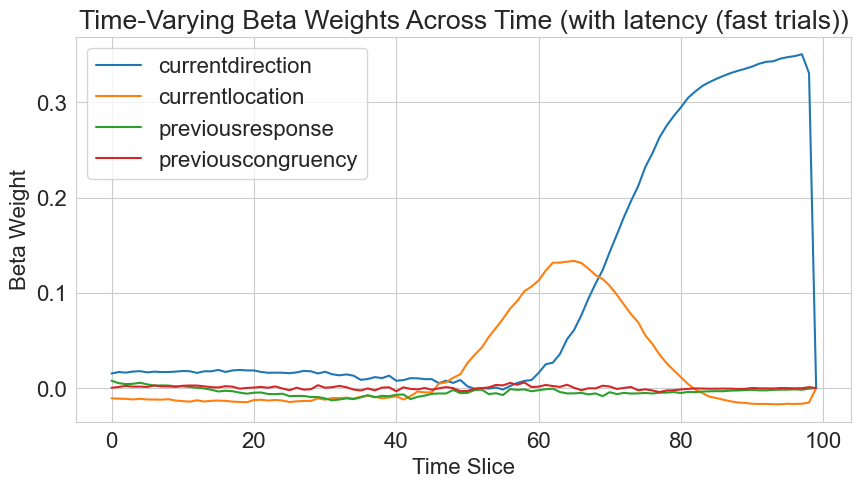

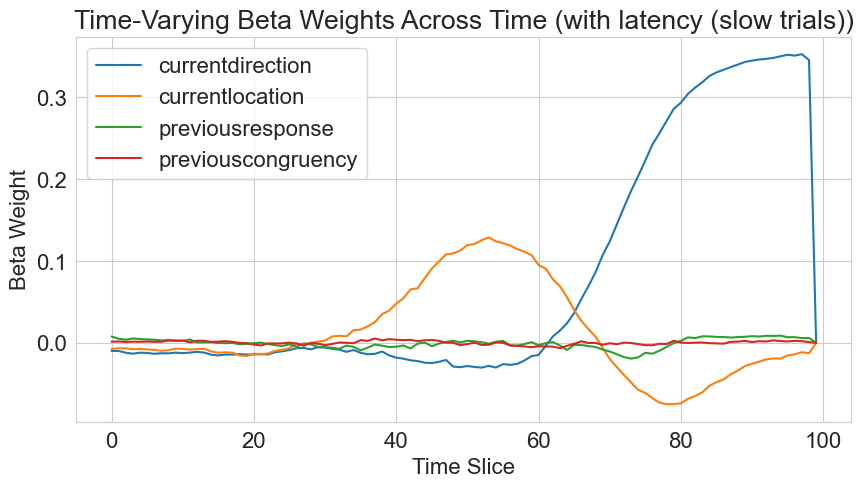

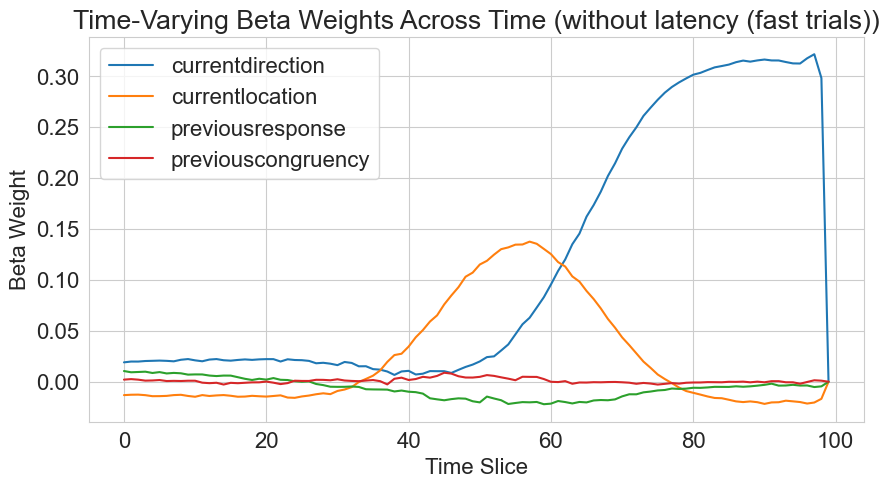

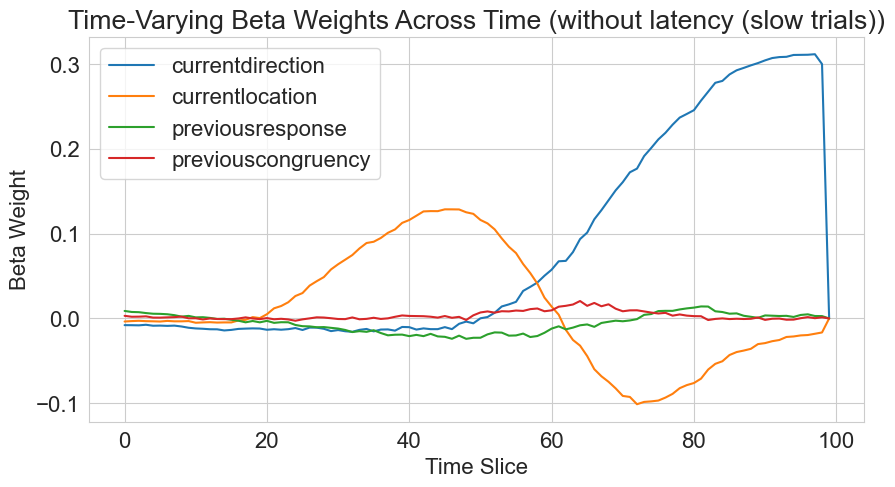

In [37]:
for beta_weights in beta_weights_all:
    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.plot(beta_weights["weights"].index, beta_weights["weights"].iloc[:, i], label=f"{predictor_columns[i]}")
    plt.xlabel("Time Slice")
    plt.ylabel("Beta Weight")
    plt.legend()
    plt.title(f"Time-Varying Beta Weights Across Time ({beta_weights['label']})")
    plt.show()


#### get peaks (values and indices)

In [38]:
def get_peak_values_and_indices(df, condition_label):
    beta_weights_np = df.to_numpy()

    peak_beta_values = np.max(beta_weights_np, axis = 0)
    peak_beta_indices = np.argmax(beta_weights_np, axis = 0)

    for i, pred in enumerate(predictor_columns):
        print(f"{pred} ({condition_label}): Peak at slice: {peak_beta_indices[i] + 1} (value: {peak_beta_values[i]})") 


In [39]:
get_peak_values_and_indices(beta_weights_with_latency_fast, "With latency (fast)")
print("\n")

get_peak_values_and_indices(beta_weights_with_latency_slow, "With latency (slow)")
print("\n")

get_peak_values_and_indices(beta_weights_no_latency_fast, "No latency (fast)")
print("\n")

get_peak_values_and_indices(beta_weights_no_latency_slow, "No latency (slow)")

currentdirection (With latency (fast)): Peak at slice: 98 (value: 0.3504048755849683)
currentlocation (With latency (fast)): Peak at slice: 66 (value: 0.13347547474498941)
previousresponse (With latency (fast)): Peak at slice: 1 (value: 0.007669410791795612)
previouscongruency (With latency (fast)): Peak at slice: 59 (value: 0.005899659338470061)


currentdirection (With latency (slow)): Peak at slice: 98 (value: 0.35261031865104486)
currentlocation (With latency (slow)): Peak at slice: 54 (value: 0.12878519543094857)
previousresponse (With latency (slow)): Peak at slice: 95 (value: 0.008785015384344523)
previouscongruency (With latency (slow)): Peak at slice: 38 (value: 0.00524987471609121)


currentdirection (No latency (fast)): Peak at slice: 98 (value: 0.32127905635343734)
currentlocation (No latency (fast)): Peak at slice: 58 (value: 0.1374456966202519)
previousresponse (No latency (fast)): Peak at slice: 1 (value: 0.010501383534113085)
previouscongruency (No latency (fast)): Peak

### Replikations-Tests für Krümmungswinkel (T-tests against zero & paired t-tests)

In [40]:
def get_peak_times(df_times, slice_factor, included_participants="all"):
    if included_participants != "all":
        df = df_times[df_times["participant_num"].isin(included_participants)]
    else: 
        df = df_times

    # Compute mean reaction time
    mean_rt = df["reactiontime"].mean()
    
    # Scale mean reaction time by the given factor (convert factor to 0.01 - 1 range)
    scaled_mean_rt = mean_rt * (slice_factor / 100)
    
    return scaled_mean_rt
    

def analyze_beta_weights_jackknife(subject_beta_weights_cond1, subject_beta_weights_cond2, subject_times_cond1, subject_times_cond2, condition_1_label, condition_2_label):    
    n_subjects = len(subject_beta_weights_cond1)
    n_predictors = subject_beta_weights_cond1[1].shape[0]
    n_timepoints = subject_beta_weights_cond1[1].shape[1]
    
    # Dictionary to store results
    results = {condition_1_label: {}, condition_2_label: {}}
    
    # Process each condition
    for condition_name, subject_data in [(condition_1_label, subject_beta_weights_cond1), 
                                         (condition_2_label, subject_beta_weights_cond2)]:
        if condition_name == condition_1_label:
            condition_times = subject_times_cond1
        else:
            condition_times = subject_times_cond2
            
        #print(subject_data[1][0][0])
        # Calculate grand average across all subjects for each predictor
        #grand_avg = np.zeros((n_predictors, n_timepoints))
        
        #print(subject_data[1][0])
        #for subject in subject_data:
            #for subject_arr in subject_data[subject]:
                #grand_avg += subject_arr
            
        #grand_avg /= n_subjects

        #beta_avg = np.mean(np.array(list(beta_weights_per_participant.values())), axis = 0)
        
        # Analyze each predictor
        for pred_idx, predictor_name in enumerate(predictor_columns):
            # Extract beta weights for this predictor from grand average

            grand_avg = np.zeros((1, n_timepoints))

            for subject in subject_data:
                grand_avg += subject_data[subject][pred_idx]
            
            grand_avg /= n_subjects

            beta_weights_pred = grand_avg[0]
            #print(beta_weights_pred)
            
            # Find peak in grand average (maximum absolute beta)
            peak_idx = np.argmax(beta_weights_pred)
            peak_beta = beta_weights_pred[peak_idx]
            peak_time = get_peak_times(condition_times, peak_idx+1)
            
            # Perform jackknifing
            jackknife_peaks = []
            jackknife_times = []
            jackknife_beta_at_peak = []
            
            for leave_out in range(n_subjects):
                # Create jackknife sample by leaving one subject out
                jk_avg = np.zeros((1, n_timepoints))
                included_subjects = [s for i, s in enumerate(subject_data) if i != leave_out]
            

                for subject in included_subjects:
                    jk_avg += subject_data[subject][pred_idx]
                
                jk_avg /= len(included_subjects)
                
                # Get beta weights for this predictor in jackknife sample
                jk_betas = jk_avg[0]
                
                # Find peak in jackknife sample
                jk_peak_idx = np.argmax(jk_betas)
                jackknife_peaks.append(jk_betas[jk_peak_idx])
                jackknife_times.append(get_peak_times(condition_times, jk_peak_idx+1, included_subjects))
                
                # Also get beta at the original peak time for variance estimation
                jackknife_beta_at_peak.append(jk_betas[peak_idx])
            
            # Calculate SE using jackknife estimates at the original peak time
            se_peak = sem(jackknife_beta_at_peak)
            
            # One-sample t-test against zero
            t_stat = peak_beta / se_peak
            df_t = n_subjects - 1
            p_value = 2 * (1 - t.cdf(abs(t_stat), df_t))  # Two-tailed
            
            # Store results
            results[condition_name][predictor_name] = {
                'peak_slice': peak_idx,
                'peak_time_ms': peak_time,
                'peak_beta': peak_beta,
                'se_beta': se_peak,
                't_statistic': t_stat,
                'p_value': p_value,
                'df': df_t,
                'jackknife_beta_values': jackknife_beta_at_peak,
                'jackknife_peak_times': jackknife_times
            }
    
    # Compare conditions with paired t-tests
    results['comparisons'] = {}
    for pred_idx, predictor_name in enumerate(predictor_columns):
        # Compare peak times between conditions
        time_diffs = []
        beta_diffs = []
        
        for i in range(n_subjects):
            # For each jackknife sample, get timing and beta differences
            time1 = results[condition_1_label][predictor_name]['jackknife_peak_times'][i]
            time2 = results[condition_2_label][predictor_name]['jackknife_peak_times'][i]
            time_diffs.append(time1 - time2)
            
            beta1 = results[condition_1_label][predictor_name]['jackknife_beta_values'][i]
            beta2 = results[condition_2_label][predictor_name]['jackknife_beta_values'][i]
            beta_diffs.append(beta1 - beta2)
        
        # Calculate statistics for timing differences
        mean_time_diff = np.mean(time_diffs)
        se_time_diff = sem(time_diffs)
        t_stat_time = mean_time_diff / se_time_diff if se_time_diff > 0 else 0
        p_value_time = 2 * (1 - t.cdf(abs(t_stat_time), n_subjects-1)) if se_time_diff > 0 else 1.0
        
        # Calculate statistics for beta differences
        #mean_beta_diff = np.mean(beta_diffs)
        #se_beta_diff = sem(beta_diffs)
        #t_stat_beta = mean_beta_diff / se_beta_diff if se_beta_diff > 0 else 0
        #p_value_beta = 2 * (1 - t.cdf(abs(t_stat_beta), n_subjects-1)) if se_beta_diff > 0 else 1.0
        
        results['comparisons'][predictor_name] = {
            'timing_t': abs(t_stat_time),
            'timing_p': p_value_time,
            'df': n_subjects - 1
        }
    
    return results

def format_results(results, condition_1_label, condition_2_label):
    """Format the results into readable text similar to the example output."""
    formatted_results = []
    
    # Format for each condition
    for condition_name in [condition_1_label, condition_2_label]:
        formatted_results.append(f"Results for {condition_name}: \n")
        
        for i, (predictor_name, result) in enumerate(results[condition_name].items()):
            p_value = result['p_value']
            
            # Format p-value
            if p_value < 0.001:
                p_str = "p < .001"
            elif p_value < 0.01:
                p_str = "p < .01"
            elif p_value < 0.05:
                p_str = "p < .05"
            else:
                p_str = f"p = {p_value:.3f}"
            
            # Format the output similar to the example
            formatted_text = (
                f"The influence of {predictor_columns[i]} peaked at slice "
                f"{result['peak_slice']+1} (M(time) = {result['peak_time_ms']:.0f} ms, "
                f"M(beta) = {result['peak_beta']:.2f}, SE(beta) = {result['se_beta']:.4f}, "
                f"t({result['df']}) = {result['t_statistic']:.2f}, {p_str}). "
            )
            
            formatted_results.append(formatted_text)
        
        formatted_results.append("")  # Add blank line between conditions
    
    # Format comparisons between conditions
    formatted_results.append("Comparisons between conditions: \n")
    for i, (predictor_name, comparison) in enumerate(results['comparisons'].items()):
        timing_p = comparison['timing_p']
        
        # Format p-values
        timing_p_str = "p < .001" if timing_p < 0.001 else f"p = {timing_p:.3f}"
        #magnitude_p_str = "p < .001" if magnitude_p < 0.001 else f"p = {magnitude_p:.3f}"
        
        formatted_text = (
            f"For {predictor_columns[i]}, the timing shift between bins was "
            f"t({comparison['df']}) = {comparison['timing_t']:.2f}, {timing_p_str}. "
        )
        
        formatted_results.append(formatted_text)
    
    return "\n".join(formatted_results)

In [41]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_fast, beta_weights_per_participant_with_latency_slow, mean_reactiontimes_per_participant_with_latency_fast, mean_reactiontimes_per_participant_with_latency_slow, "with_latency_fast", "with_latency_slow")

print('Comparison of beta weight peaks for trials with latency \n')
print(format_results(results, "with_latency_fast", "with_latency_slow"))

Comparison of beta weight peaks for trials with latency 

Results for with_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 413 ms, M(beta) = 0.35, SE(beta) = 0.0010, t(15) = 338.37, p < .001). 
The influence of currentlocation peaked at slice 66 (M(time) = 278 ms, M(beta) = 0.13, SE(beta) = 0.0011, t(15) = 121.03, p < .001). 
The influence of previousresponse peaked at slice 1 (M(time) = 4 ms, M(beta) = 0.01, SE(beta) = 0.0006, t(15) = 12.32, p < .001). 
The influence of previouscongruency peaked at slice 59 (M(time) = 248 ms, M(beta) = 0.01, SE(beta) = 0.0002, t(15) = 34.45, p < .001). 

Results for with_latency_slow: 

The influence of currentdirection peaked at slice 98 (M(time) = 556 ms, M(beta) = 0.35, SE(beta) = 0.0013, t(15) = 279.86, p < .001). 
The influence of currentlocation peaked at slice 54 (M(time) = 306 ms, M(beta) = 0.13, SE(beta) = 0.0011, t(15) = 112.55, p < .001). 
The influence of previousresponse peaked at slice 95 (M(time) = 539 ms

In [42]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_no_latency_fast, beta_weights_per_participant_no_latency_slow, mean_reactiontimes_per_participant_no_latency_fast, mean_reactiontimes_per_participant_no_latency_slow, "no_latency_fast", "no_latency_slow")

print('Comparison of beta weight peaks for trials without latency \n')
print(format_results(results, "no_latency_fast", "no_latency_slow"))

Comparison of beta weight peaks for trials without latency 

Results for no_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 352 ms, M(beta) = 0.32, SE(beta) = 0.0011, t(15) = 289.48, p < .001). 
The influence of currentlocation peaked at slice 58 (M(time) = 208 ms, M(beta) = 0.14, SE(beta) = 0.0010, t(15) = 137.24, p < .001). 
The influence of previousresponse peaked at slice 1 (M(time) = 4 ms, M(beta) = 0.01, SE(beta) = 0.0005, t(15) = 21.57, p < .001). 
The influence of previouscongruency peaked at slice 46 (M(time) = 165 ms, M(beta) = 0.01, SE(beta) = 0.0002, t(15) = 45.95, p < .001). 

Results for no_latency_slow: 

The influence of currentdirection peaked at slice 98 (M(time) = 506 ms, M(beta) = 0.31, SE(beta) = 0.0012, t(15) = 255.77, p < .001). 
The influence of currentlocation peaked at slice 46 (M(time) = 237 ms, M(beta) = 0.13, SE(beta) = 0.0010, t(15) = 130.35, p < .001). 
The influence of previousresponse peaked at slice 82 (M(time) = 423 ms,

### Vergleich zwischen Conditions in Hinsicht auf Krümmungswinkel

#### Extrahieren der Beta Weights pro Subjekt, der mean reactiontimes und grand averages

In [43]:
beta_weights_per_participant_with_latency_overall = get_beta_weights_per_participant(df_with_latency)
beta_weights_per_participant_no_latency_overall = get_beta_weights_per_participant(df_no_latency)

mean_reactiontimes_per_participant_with_latency_overall = get_mean_times_per_participant(df_with_latency)
mean_reactiontimes_per_participant_no_latency_overall= get_mean_times_per_participant(df_no_latency)

beta_weights_with_latency_overall = trajectory_angle_multiple_regression(df_with_latency)
beta_weights_no_latency_overall = trajectory_angle_multiple_regression(df_no_latency)

#### Peaks bei Gruppe mit Latenz

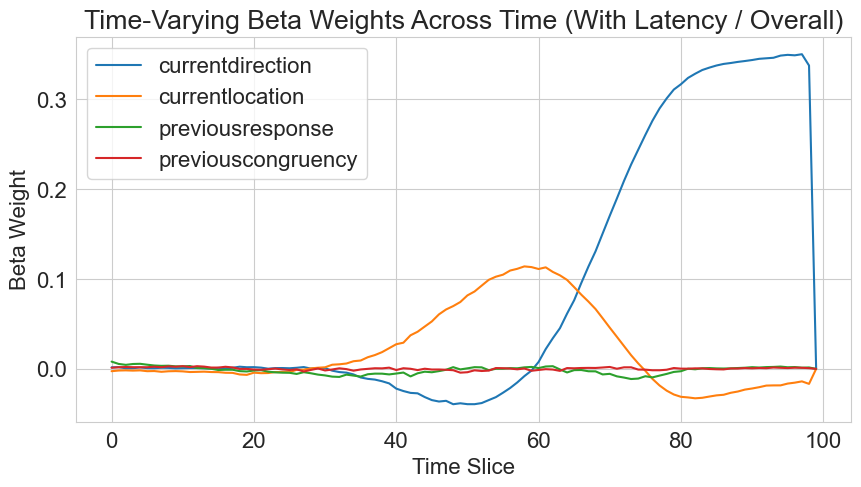

In [44]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(beta_weights_with_latency_overall.index, beta_weights_with_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
plt.xlabel("Time Slice")
plt.ylabel("Beta Weight")
plt.legend()
plt.title(f"Time-Varying Beta Weights Across Time (With Latency / Overall)")
plt.show()


In [57]:
def plot_distance_from_endpoint(df, title, ax=None):
    # Sammeln aller normalisierten Entfernungen für jede Zeitposition
    position_distances = [[] for _ in range(100)]
    
    # Durchlaufe jede Mausbewegung (jede Zeile im DataFrame)
    for idx, row in df.iterrows():
        # Extrahiere x und y Koordinaten für diese Bewegung
        x_coords = row['xpos']
        y_coords = row['ypos']
        
        # Falls weniger als 100 Punkte, überspringe oder fülle auf
        if len(x_coords) < 100:
            continue
        
        # Endpunkt dieser spezifischen Bewegung
        end_x = x_coords[-1]
        end_y = y_coords[-1]
        
        # Startpunkt dieser Bewegung
        start_x = x_coords[0]
        start_y = y_coords[0]
        
        # Maximale Entfernung (vom Start zum Endpunkt)
        max_distance = np.sqrt((start_x - end_x)**2 + (start_y - end_y)**2)
        
        # Berechne prozentuale Entfernung jedes Punktes zum Endpunkt
        for i in range(min(len(x_coords), 100)):
            dist = np.sqrt((x_coords[i] - end_x)**2 + (y_coords[i] - end_y)**2)
            # Umrechnung in Prozent der maximalen Entfernung
            if max_distance > 0:  # Vermeidung von Division durch Null
                percent_dist = (dist / max_distance) * 100
                position_distances[i].append(percent_dist)
    
    # Berechne verschiedene Perzentile für jede Position
    x_values = np.linspace(0, 100, 100)  # Zeitliche Progression (0-100%)
    
    # Berechne Median und Perzentile für jede Position
    median_values = []
    percentile_25 = []
    percentile_75 = []
    
    for dists in position_distances:
        if dists:
            median_values.append(np.median(dists))
            percentile_25.append(np.percentile(dists, 25))
            percentile_75.append(np.percentile(dists, 75))
        else:
            median_values.append(np.nan)
            percentile_25.append(np.nan)
            percentile_75.append(np.nan)

    if ax is None:
        ax = plt.gca()
    
    ax.plot(x_values, median_values, label='Median')
    ax.fill_between(x_values, percentile_25, percentile_75, alpha=0.3, label='25-75% Percentile')
    
    # Invertiere die y-Achse (100% unten, 0% oben)
    ax.invert_yaxis()
    
    ax.set_xlabel('Time Slice')
    ax.set_ylabel('Distance to Endpoint (%)')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

# Beispielaufruf:
# plot_distance_from_endpoint(df)

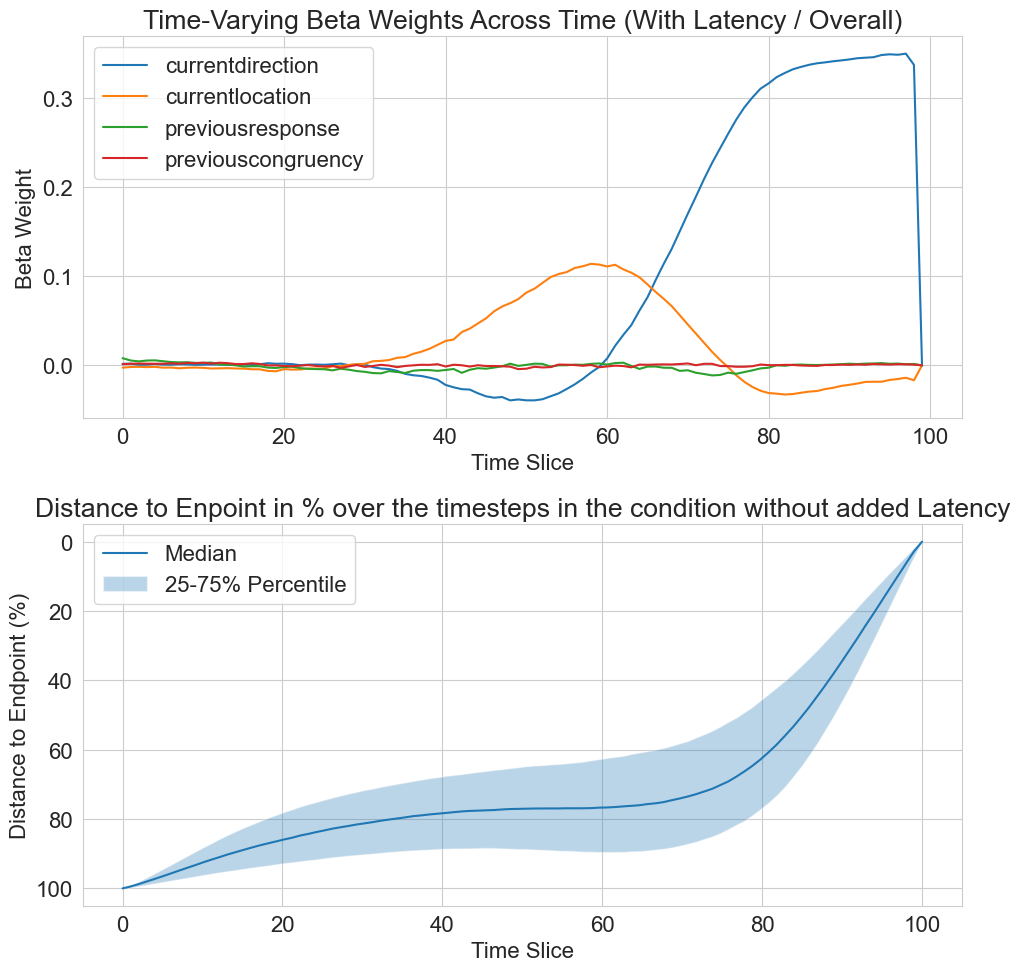

In [58]:
# Erstelle eine Figur mit zwei Subplots (1 Zeile, 2 Spalten)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Erster Plot: Beta Weights mit Latency / Overall
for i in range(4):
    ax[0].plot(beta_weights_with_latency_overall.index, beta_weights_with_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
ax[0].set_xlabel("Time Slice")
ax[0].set_ylabel("Beta Weight")
ax[0].legend()
ax[0].set_title("Time-Varying Beta Weights Across Time (With Latency / Overall)")

# Zweiter Plot: plot_distance_from_endpoint im Subplot ax[1]
plot_distance_from_endpoint(df_with_latency, title="Distance to Enpoint in % over the timesteps in the condition without added Latency", ax=ax[1])

# Anpassung und Anzeigen der Plots
plt.tight_layout()
plt.show()

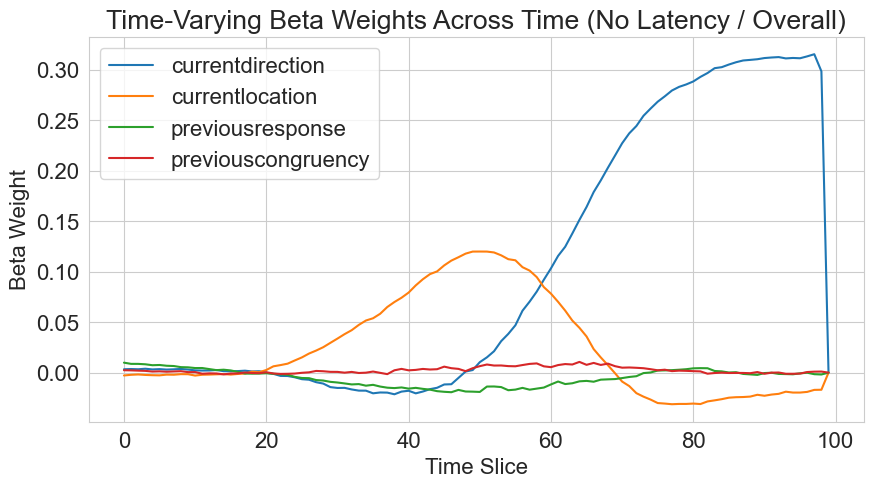

In [59]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(beta_weights_no_latency_overall.index, beta_weights_no_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
plt.xlabel("Time Slice")
plt.ylabel("Beta Weight")
plt.legend()
plt.title(f"Time-Varying Beta Weights Across Time (No Latency / Overall)")
plt.show()

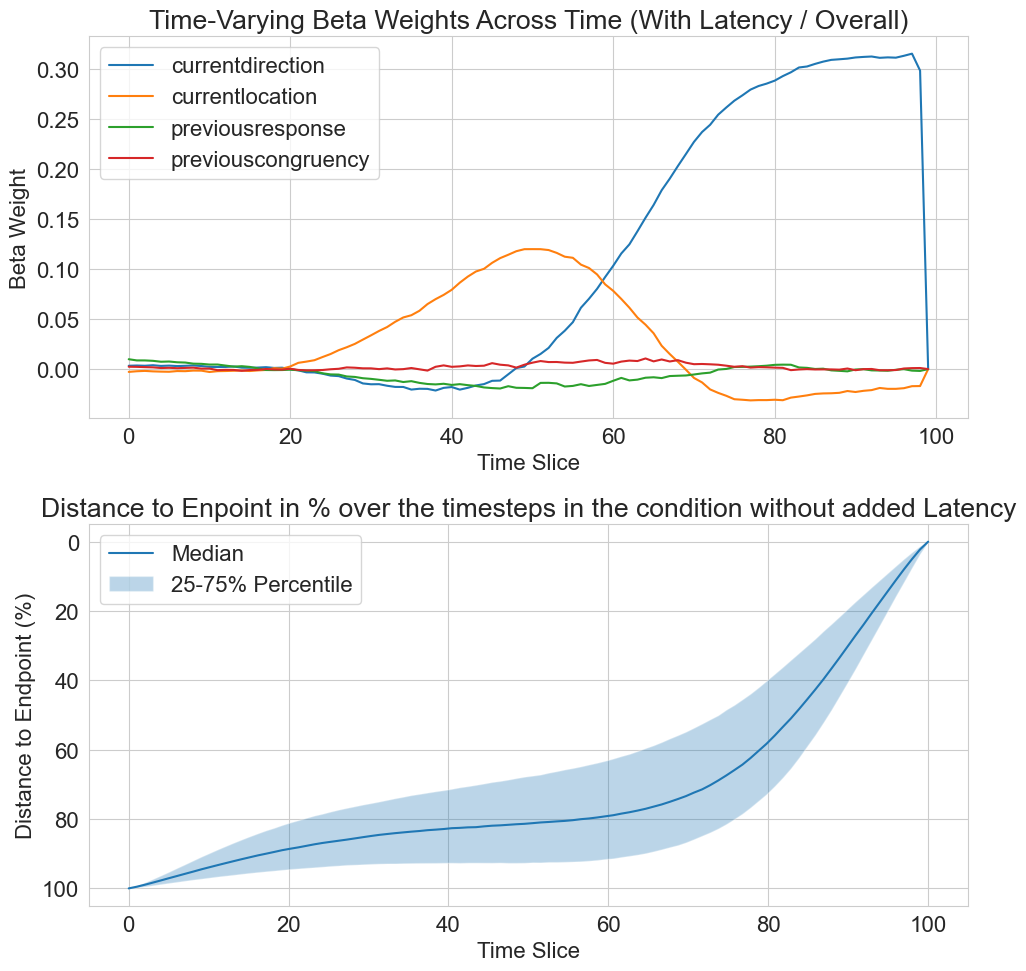

In [60]:
# Erstelle eine Figur mit zwei Subplots (1 Zeile, 2 Spalten)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Erster Plot: Beta Weights no Latency / Overall
for i in range(4):
    ax[0].plot(beta_weights_no_latency_overall.index, beta_weights_no_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
ax[0].set_xlabel("Time Slice")
ax[0].set_ylabel("Beta Weight")
ax[0].legend()
ax[0].set_title("Time-Varying Beta Weights Across Time (With Latency / Overall)")

# Zweiter Plot: plot_distance_from_endpoint im Subplot ax[1]
plot_distance_from_endpoint(df_no_latency, title="Distance to Enpoint in % over the timesteps in the condition without added Latency", ax=ax[1])



# Anpassung und Anzeigen der Plots
plt.tight_layout()
plt.show()

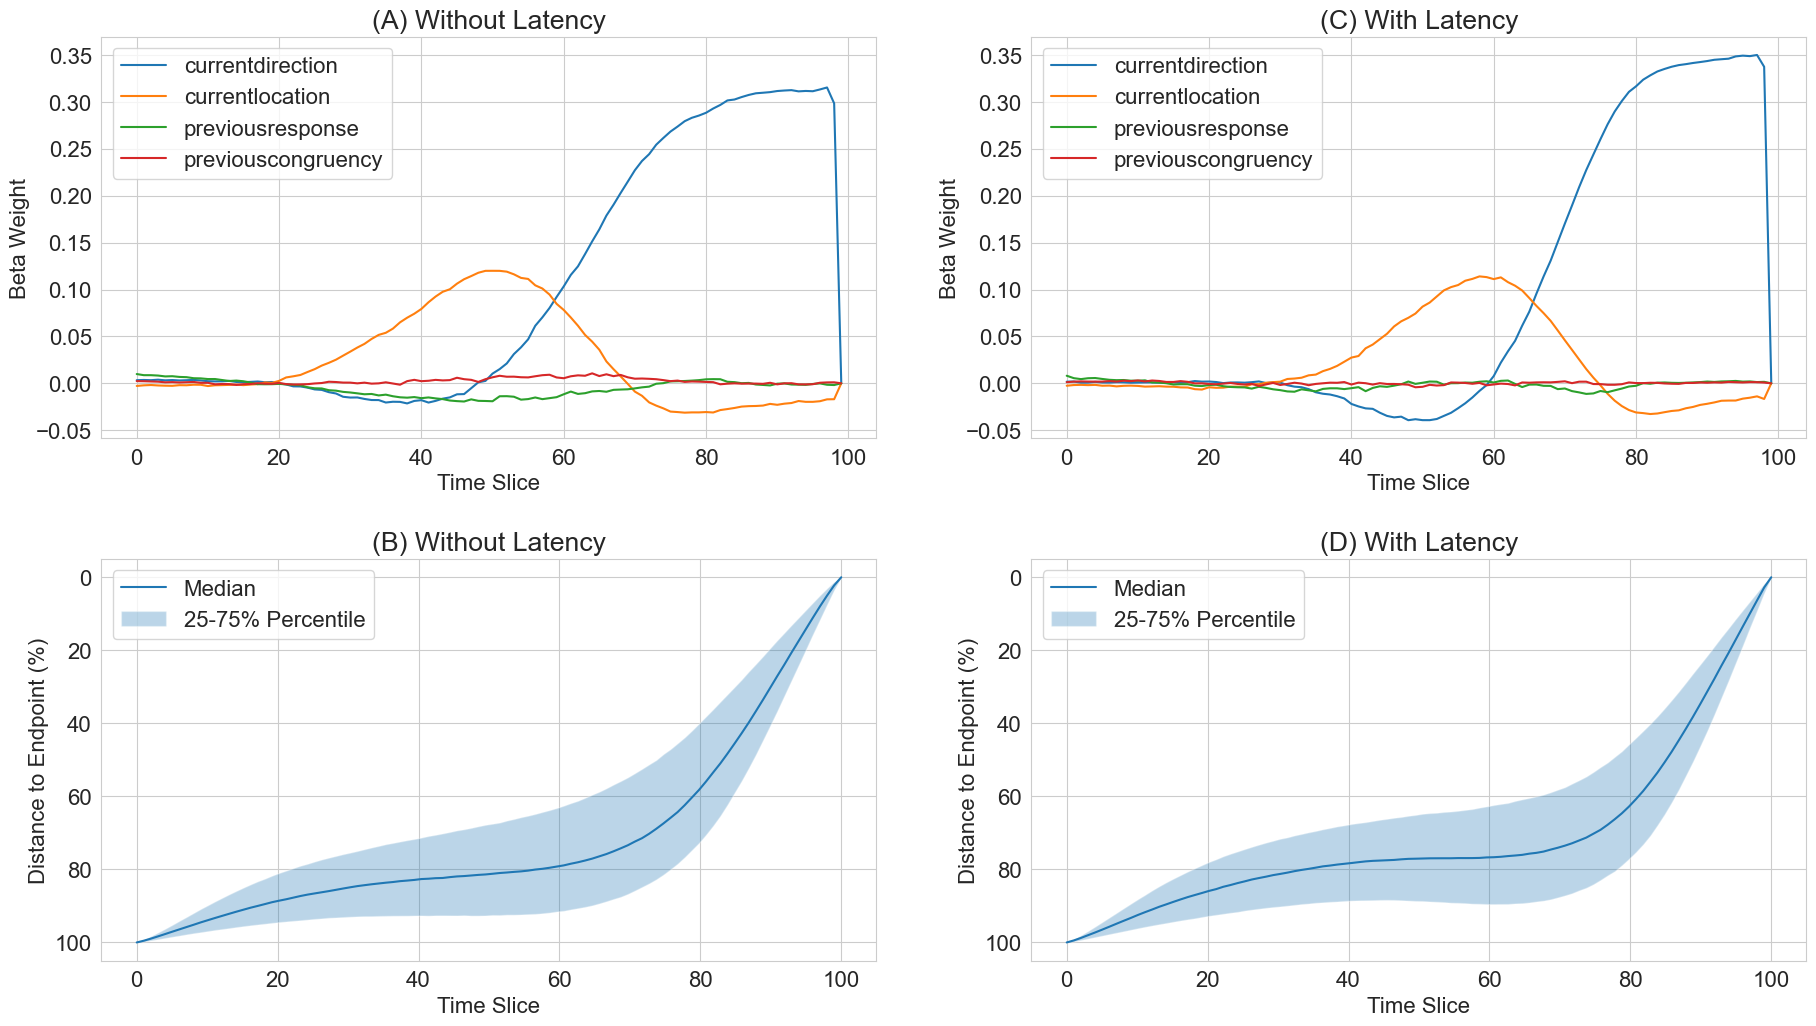

In [61]:
# Beide zusammen
# Erstelle eine Figur mit zwei Subplots (1 Zeile, 2 Spalten)
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(22, 12))

for i in range(4):
    ax[0, 0].plot(beta_weights_no_latency_overall.index, beta_weights_no_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
ax[0, 0].set_xlabel("Time Slice")
ax[0, 0].set_ylabel("Beta Weight")
ax[0, 0].legend()
ax[0, 0].set_title("(A) Without Latency")

plot_distance_from_endpoint(df_no_latency, title="(B) Without Latency", ax=ax[1, 0])

for i in range(4):
    ax[0, 1].plot(beta_weights_with_latency_overall.index, beta_weights_with_latency_overall.iloc[:, i], label=f"{predictor_columns[i]}")
ax[0, 1].set_xlabel("Time Slice")
ax[0, 1].set_ylabel("Beta Weight")
ax[0, 1].legend()
ax[0, 1].set_title("(C) With Latency")

y_min_beta = min(ax[0, 0].get_ylim()[0], ax[0, 1].get_ylim()[0])
y_max_beta = max(ax[0, 0].get_ylim()[1], ax[0, 1].get_ylim()[1])
ax[0, 0].set_ylim([y_min_beta, y_max_beta])
ax[0, 1].set_ylim([y_min_beta, y_max_beta])

plot_distance_from_endpoint(df_with_latency, title="(D) With Latency", ax=ax[1, 1])

# Anpassung und Anzeigen der Plots
plt.subplots_adjust(wspace=0.2, hspace=0.3)
#plt.tight_layout()
plt.show()

#### T-Tests against zero und paired t-tests (zwischen Latenzkonditionen)

In [50]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_overall, beta_weights_per_participant_no_latency_overall, mean_reactiontimes_per_participant_with_latency_overall
, mean_reactiontimes_per_participant_no_latency_overall, "with_latency", "no_latency")

print('Comparison of beta weight peaks for trials with latency and trials without\n')
print(format_results(results, "with_latency", "no_latency"))

Comparison of beta weight peaks for trials with latency and trials without

Results for with_latency: 

The influence of currentdirection peaked at slice 98 (M(time) = 484 ms, M(beta) = 0.35, SE(beta) = 0.0011, t(15) = 308.28, p < .001). 
The influence of currentlocation peaked at slice 59 (M(time) = 291 ms, M(beta) = 0.11, SE(beta) = 0.0008, t(15) = 141.27, p < .001). 
The influence of previousresponse peaked at slice 1 (M(time) = 5 ms, M(beta) = 0.01, SE(beta) = 0.0006, t(15) = 12.67, p < .001). 
The influence of previouscongruency peaked at slice 11 (M(time) = 54 ms, M(beta) = 0.00, SE(beta) = 0.0001, t(15) = 31.69, p < .001). 

Results for no_latency: 

The influence of currentdirection peaked at slice 98 (M(time) = 429 ms, M(beta) = 0.32, SE(beta) = 0.0011, t(15) = 278.21, p < .001). 
The influence of currentlocation peaked at slice 51 (M(time) = 223 ms, M(beta) = 0.12, SE(beta) = 0.0008, t(15) = 146.42, p < .001). 
The influence of previousresponse peaked at slice 1 (M(time) = 4 

#### t-tests zwischen schnellen Bins (Latenz vs ohne Latenz)

In [51]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_fast, beta_weights_per_participant_no_latency_fast, mean_reactiontimes_per_participant_with_latency_fast, mean_reactiontimes_per_participant_no_latency_fast, "with_latency_fast", "no_latency_fast")

print('Comparison of beta weight peaks for fast trials \n')
print(format_results(results, "with_latency_fast", "no_latency_fast"))

Comparison of beta weight peaks for fast trials 

Results for with_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 413 ms, M(beta) = 0.35, SE(beta) = 0.0010, t(15) = 338.37, p < .001). 
The influence of currentlocation peaked at slice 66 (M(time) = 278 ms, M(beta) = 0.13, SE(beta) = 0.0011, t(15) = 121.03, p < .001). 
The influence of previousresponse peaked at slice 1 (M(time) = 4 ms, M(beta) = 0.01, SE(beta) = 0.0006, t(15) = 12.32, p < .001). 
The influence of previouscongruency peaked at slice 59 (M(time) = 248 ms, M(beta) = 0.01, SE(beta) = 0.0002, t(15) = 34.45, p < .001). 

Results for no_latency_fast: 

The influence of currentdirection peaked at slice 98 (M(time) = 352 ms, M(beta) = 0.32, SE(beta) = 0.0011, t(15) = 289.48, p < .001). 
The influence of currentlocation peaked at slice 58 (M(time) = 208 ms, M(beta) = 0.14, SE(beta) = 0.0010, t(15) = 137.24, p < .001). 
The influence of previousresponse peaked at slice 1 (M(time) = 4 ms, M(beta) = 0

#### t-test zwischen langsamen Bins (latenz vs ohne Latenz)

In [52]:
results = analyze_beta_weights_jackknife(beta_weights_per_participant_with_latency_slow, beta_weights_per_participant_no_latency_slow, mean_reactiontimes_per_participant_with_latency_slow, mean_reactiontimes_per_participant_no_latency_slow, "with_latency_slow", "no_latency_slow")

print('Comparison of beta weight peaks for slow trials \n')
print(format_results(results, "with_latency_slow", "no_latency_slow"))

Comparison of beta weight peaks for slow trials 

Results for with_latency_slow: 

The influence of currentdirection peaked at slice 98 (M(time) = 556 ms, M(beta) = 0.35, SE(beta) = 0.0013, t(15) = 279.86, p < .001). 
The influence of currentlocation peaked at slice 54 (M(time) = 306 ms, M(beta) = 0.13, SE(beta) = 0.0011, t(15) = 112.55, p < .001). 
The influence of previousresponse peaked at slice 95 (M(time) = 539 ms, M(beta) = 0.01, SE(beta) = 0.0002, t(15) = 42.62, p < .001). 
The influence of previouscongruency peaked at slice 38 (M(time) = 215 ms, M(beta) = 0.01, SE(beta) = 0.0003, t(15) = 17.58, p < .001). 

Results for no_latency_slow: 

The influence of currentdirection peaked at slice 98 (M(time) = 506 ms, M(beta) = 0.31, SE(beta) = 0.0012, t(15) = 255.77, p < .001). 
The influence of currentlocation peaked at slice 46 (M(time) = 237 ms, M(beta) = 0.13, SE(beta) = 0.0010, t(15) = 130.35, p < .001). 
The influence of previousresponse peaked at slice 82 (M(time) = 423 ms, M(bet